The most recent version of this notebook is available at https://github.com/nadiinchi/dl_labs/blob/master/lab_attention.ipynb

This notebook contains a practical introduction to the mechanisms of attention.
The notebook is considering a toy problem and architecture, so it can be implemented and computed on the CPU.

## Theory

There are $K$ objects that you can pay attention to.
Each object is characterized by the key $k_i$ and the value $v_i$.
The attention layer proceeds requests.
For the query $q$, the layer returns a weighted sum of the values of the objects, with weights proportional to the degree of key matching the query:
$$w_i = \frac{\exp(score(q, k_i))}{\sum_{j=1}^K\exp(score(q, k_j))}$$
$$a = \sum_{i=1}^K w_i v_i$$

Almost always, queries, keys, and values are real vectors of some fixed dimensions.
In the assignment it is proposed to implement three types of attention:
+ Multiplicative Attention.
Defined by function $score(q, k) = q^Tk$.
To use this type of attention, it is required that the dimension of the query coincides with the dimension of the key.
For more information see the paper Luong et al. "Effective approaches to attention-based neural machine translation", 2015.
+ Scaled Dot Product Attention.
Defined by function $score(q, k) = \frac{q^Tk}{\sqrt{dim(k)}}$, where $dim(k)$ is the dimensionality of the key (which also equals the dimensionality of the query).
With learnable queries or keys, such attention is equivalent to multiplicative attention described above.
However, immediately after initialization, such attention encourages smoother weights, which alleviates the problem of small gradients for saturated SoftMax.
For more information see the paper Vaswani et al. "Attention Is All You Need", 2017.
+ _(Optional, you may implement it after finishing the main part)._ Additive Attention. 
Defined by function $ score (q, k) = w_3 ^ T \ tanh (W_1q + W_2k) $, where $ W_1, W_2, w_3 $ are the trainable parameters of the attention layer.
For such a function, the request and key may have different dimensions.
Matrices $ W_1 $ and $ W_2 $ map the query and key into a common hidden space, the dimension of which coincides with the dimension of the vector $ w_3 $.
The dimension of the hidden space can be chosen arbitrarily and is a hyperparameter of the layer.
For more information see the paper Bahdanau et al. "Neural Machine Translation by Jointly Learning to Align and Translate", 2014.

In practice, the keys and values of the objects are usually the same vector by the model design.
In this case keys and values of objects are also called objects' features (i. e. $f_i := k_i = v_i$).

_An attention mask_ was proposed in the paper Vaswani et al. "Attention Is All You Need", 2017.
Mask shows for each query which objects it cannot pay attention to.
It sets $w_j := 0$ for $i$-th query if $mask_{i, j} = 1$.
Note that weights still must sum up to $1$ for every query, i. e. the weights that was not zeroed must be renormalized.

A mask where $mask_{i, j} = \text{Indicator}[i < j]$ is used to ensure the autoregressive properties of the model.
I. e. the layer output for the $i$-th position does not depend on the input values of subsequent positions.

## Practice

Below it is proposed to implement several models of attention, described in the abovementioned articles.

For the flexibility of the interface and for the acceleration of learning, all layers of attention below receive several requests for each object of the batch.

### Score layers

In each of classes `MultiplicativeScore` and `ScaledDotProductScore`, you need to implement function `forward`.
It takes a tensor of `queries` (of shape `batch_size x num_queries x query_dim`) and a tensor of objects' `features` (of shape `batch_size x num_objects x features_dim`).
It computes for each pair of object and query inside batch their similarity score.
The output tensor have shape `batch_size x num_queries x num_objects`.
The code should be equivalent to the following:
```
res = torch.zeros(batch_size, num_queries, num_objects)
for i in range(batch_size):
    for j in range(num_queries):
        for k in range(num_objects):
            res[i, j, k] = score(queries[i, j], features[i, k])
```

Naturally, the above code is only an illustration explaining the dimensions of the arguments and the output of the `forward` function.
Your implementation must be effectively vectorized.

_Hint:_ It is recommended to pay attention to the function torch.bmm, it may be useful below.

In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import math

In [2]:
class MultiplicativeScore(nn.Module):
    """
    Luong et al. "Effective approaches to attention-based neural machine translation", 2015.
    """
    def __init__(self):
        super().__init__()

    def forward(self, queries, features):
        """
        queries:  [batch_size x num_queries x dim]
        features: [batch_size x num_objects x dim]
        Returns a tensor of scores with shape [batch_size x num_queries x num_objects].
        """
        # your code here
        return result

In [3]:
class ScaledDotProductScore(nn.Module):
    """
    Vaswani et al. "Attention Is All You Need", 2017.
    """
    def __init__(self):
        super().__init__()

    def forward(self, queries, features):
        """
        queries:  [batch_size x num_queries x dim]
        features: [batch_size x num_objects x dim]
        Returns atensor of scores with shape [batch_size x num_queries x num_objects].
        """
        # your code here
        return result

#### Tests for score function

In [4]:
q = torch.tensor([[
    [0, 0, 0, 0, 1],
    [0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0],
]], dtype=torch.float32)
o = torch.tensor([[
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
]], dtype=torch.float32)
print(MultiplicativeScore()(q, o))
print(ScaledDotProductScore()(q, o))

tensor([[[1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 0.]]])
tensor([[[0.4472, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4472, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]]])


In [5]:
q = torch.randn(2, 3, 5)
o = torch.randn(2, 4, 5)
print(MultiplicativeScore()(q, o).shape)
print(ScaledDotProductScore()(q, o).shape)

torch.Size([2, 3, 4])
torch.Size([2, 3, 4])


### Attention layer

In `Attention` class it is necessary to implement function `forward`, which takes as inputs a set of `queries`, a set of `features` attributes for each batch object, and optionally an attention `mask` that is described above.
The `Attnetion` object uses the score function it gets in the constructor (either `MultiplicativeScore`, `ScaledDotProductScore`, or other score function or functor).

The most numerically stable way to use a mask in attend will be to set the corresponding score values to `float('-inf')` before applying SoftMax.
An alternative method is to zero the scales $w$ according to the mask and renormalize them, but this method is less computationally stable (think why).

To visualize the attention map at the end of the notebook, you need to save `weights.detach()` in `self.last_weights` in the `forward`. `.detach()` is used to enforce that the stored weights are not part of the computational graph. Do not forget to do `.detach()` for the debug output, so that the computational graph does not consume RAM beyond the required size.

In [6]:
class Attention(nn.Module):
    def __init__(self, scorer):
        super().__init__()
        self.scorer = scorer

    def forward(self, queries, features, mask=None):
        """
        queries:         [batch_size x num_queries x query_feature_dim]
        features:        [batch_size x num_objects x obj_feature_dim]
        mask, optional:  [num_queries x num_objects]
        Returns matrix of responses for queries with shape [batch_size x num_queries x obj_feature_dim].
        If mask is not None, sets corresponding to mask weights to zero.
        Saves detached weights as self.last_weights for further visualization.
        """
        scores = self.scorer(queries, features)
        # your code here
        weights = # your code here
        self.last_weights = weights.detach()
        # your code here
        return result

#### Tests for Attention

In [7]:
q = torch.tensor([[
    [0, 0, 0, 0, 1],
    [0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0],
]], dtype=torch.float32)
o = torch.tensor([[
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
]], dtype=torch.float32)
attn = Attention(MultiplicativeScore())
a = attn(q, o)
print(attn.last_weights)
print(a)

tensor([[[0.4754, 0.1749, 0.1749, 0.1749],
         [0.1749, 0.1749, 0.4754, 0.1749],
         [0.2500, 0.2500, 0.2500, 0.2500]]])
tensor([[[0.0000, 0.1749, 0.1749, 0.1749, 0.4754],
         [0.0000, 0.1749, 0.4754, 0.1749, 0.1749],
         [0.0000, 0.2500, 0.2500, 0.2500, 0.2500]]])


In [8]:
q = torch.randn(2, 3, 5)
o = torch.randn(2, 4, 5)
print(attn(q, o).shape)

torch.Size([2, 3, 5])


#### Tests for Attention with attention mask

In [9]:
def get_autoregressive_mask(size):
    """
    Returns attention mask of given size for autoregressive model.
    """
    res = torch.zeros(size, size, dtype=torch.uint8)
    for i in range(size - 1):
        res[i, i + 1:] = 1
    return res

In [10]:
m = get_autoregressive_mask(4)
print(m)

tensor([[0, 1, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 0]], dtype=torch.uint8)


In [11]:
q = torch.tensor([[
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0],
]], dtype=torch.float32)
o = torch.tensor([[
    [1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
]], dtype=torch.float32)
a = attn(q, o)
print(attn.last_weights)

tensor([[[0.1749, 0.1749, 0.1749, 0.4754],
         [0.1749, 0.1749, 0.4754, 0.1749],
         [0.1749, 0.4754, 0.1749, 0.1749],
         [0.4754, 0.1749, 0.1749, 0.1749]]])


In [12]:
a = attn(q, o, m)
print(attn.last_weights)

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000],
         [0.2119, 0.5761, 0.2119, 0.0000],
         [0.4754, 0.1749, 0.1749, 0.1749]]])


In [13]:
q = torch.randn(2, 4, 5)
o = torch.randn(2, 4, 5)
print(attn(q, o, m).shape)

torch.Size([2, 4, 5])


### Positional Encoder

PositionalEncoder is the layer described in Vaswani et al. "Attention Is All You Need", 2017.
The motivation is that attention is an operation over a set, i. e. it assumes no order in objects.
In order to make attention over sequence position-aware, it was proposed to add to the object
the vector of encoding of its position.

It adds to the output of the previous layer embedding positions.
In order not to recalculate position embeddings each time, its constructor receives the `max_len` parameter and precomputes embeddingings for positions from 0 to `max_len` - 1 inclusive.
The add flag indicates whether to add position embeddings to the output of the previous layer (by default, with `add` = True, as was in the original paper) or concatenated (`add` = False).
For the selected embedding dimensions, you should visualize the embeddings (plot the each component of the embeddings) and select the appropriate scale parameter.

In [14]:
class PositionalEncoder(nn.Module):
    def __init__(self, dim, max_len=50, scale=10000.0, add=True):
        """
        Transforms input as described by Vaswani et al. in "Attention Is All You Need", 2017.
        dim     - dimension of positional embeddings.
        max_len - maximal length of sequence, for precomputing
        scale   - scale factor for frequency for positional embeddings
        add     - boolean, if add is False, concatenate positional embeddings with input instead of adding
        """
        super().__init__()
        
        self.dim = dim
        self.add = add

        # your code here
               
    def forward(self, input):
        """
        input - [batch_size x sequence_len x features_dim]
        If self.add is True, self.dim = featurs_dim.
        Returns input with added or concatenated positional embeddings (depending on self.add).
        """
        # your code here
        return result

#### Test: draw positional encoder

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

# visualize postional encodings for some parameters of PositionalEncoding
# your code here

## Problem: associative memory

We have a lot of layers, let's solve some problem now!

The task at hand is the multiplication (composition) of permutations.
The length if permutations is fixed and equals perm_len.
Input is an integer vector of length 2 x perm_len which contains two concatenated permutations p1 and p2.
The product of p1 and p2 is a permutation p3 for which p3[i] = p1[p2[i]].
The output of NN is also an integer vector of length 2 x perm_len in which first perm_lem elements are zero and the second perm_len elements are permutation p3.

Example for perm_len = 5:
```
Input sequence:  3 4 2 1 0 1 3 0 2 4
Output sequence: 0 0 0 0 0 4 1 3 2 0
Clarification:  p1 = 3 4 2 1 0,    p2 = 1 3 0 2 4   =>    p3 = 4 1 3 2 0
```

Theoretically, such a problem can be solved by an ordinary LSTM, which will first memorize the permutation p1 in a hidden state, and then passing through the permutation p2 will produce the corresponding elements from the permutation p1.
In practice, however, such a model works noticeably worse than a model with attention. A model with attention is explicitly learning by going through the p2 permutation to pay attention to the desired permutation element p1 and to output it.

### Data generator

The perm_generator function generates a batch of a given size of objects for training or a test.
For each object in the batch permuations p1 and p2 of length perm_size are generated equiprobable.
They form the input sequence [p1, p2] and the correct answer [0, p3] for it (see the example above).

In [16]:
def perm_generator(batch_size, perm_size):
    """
    Generates batch of batch_size objects.
    Each object consists of two concatenated random permutations with length perm_size.
    The target for the object is the product of its two permutations.
    """
    perm1 = torch.cat([torch.randperm(perm_size).view(1, -1) for i in range(batch_size)], 0)
    perm2 = torch.cat([torch.randperm(perm_size).view(1, -1) for i in range(batch_size)], 0)
    correct = torch.zeros(batch_size, perm_size * 2, dtype=torch.long)
    for i in range(batch_size):
        for j in range(perm_size):
            correct[i, j + perm_size] = perm1[i, perm2[i, j]]
    return torch.cat([perm1, perm2], 1), correct

In [17]:
perm_generator(3, 5)

(tensor([[1, 3, 0, 4, 2, 1, 4, 2, 0, 3],
         [2, 4, 3, 1, 0, 4, 0, 1, 2, 3],
         [2, 1, 0, 4, 3, 4, 2, 0, 1, 3]]),
 tensor([[0, 0, 0, 0, 0, 3, 2, 0, 1, 4],
         [0, 0, 0, 0, 0, 0, 2, 4, 3, 1],
         [0, 0, 0, 0, 0, 3, 0, 2, 1, 4]]))

### Putting all together: permutation multiplier model

The model consists of the following layers:
1. Embedding elements of the input sequence.
2. Positional encoding.
3. Linear layer to generate queries.
4. A layer of attention. It receives the output of linear layer (3) as queries and sequence of embeddings (2) as objects.
This layer must use the attention mask to ignore sequence elements from the future.
5. Logistic regression with perm_len classes, outputs an integer for each position of answer.

Please note that this model is neither a transformer nor a traditional network using LSTM with attention.
The transformer uses K-head attention, elementwise transformation of embeddings.
In traditional networks with LSTM, it used to obtain queries like linear layer (3) in the proposedarchitecture.
But the result of query issued by LSTM at the previous time point affects the LSTM input at the next time point, therefore simultaneous parallel processing of the entire sequence is impossible.
Also, most networks use the encoder-decoder architecture, where the encoder first reads the entire input sequence and forms its hidden representation, and then the decoder outputs the output sequence using this hidden representation and attention mechanism.

In [18]:
class PermMultiplier(nn.Module):
    def __init__(self, perm_len, embedding_dim, attention, pos_enc):
        """
        perm_len       - permutation length (the input is twice longer)
        embedding_dim  - dimensionality of integer embeddings
        attention      - Attention object
        pos_enc        - PositionalEncoder object
        """
        super().__init__()
        self.attention = attention
        self.perm_len = perm_len
        self.pos_enc = pos_enc
        self.embeddings_dim = embedding_dim
        
        self.object_dim = embedding_dim
        # if PositionalEncoding concatenates its encoding instead of
        # adding it to the embeddings, then the dimensionality of
        # the object after usch transformation increases
        if not pos_enc.add:
            self.object_dim += pos_enc.dim

        # your code here

    def forward(self, input):
        """
        Perform forward pass through layers:
        + get embeddings from input sequence (using both embeddings
          and positional embeddings)
        + run linear layer on embeddings
        + use output of the previous layer as an attention queries
        + attend on the embedded sequence using queries (note autoregressiveness)
        + make final linear tranformation to obtain logits
        """
        # your code here
        return result

### Train the model

Complete the code for learning the model below.
Find the right architecture and set of hyperparameters for the model and optimization method.
For some architecture and hyperparameters the model can be trained on the CPU in a short time.

If something doesn't work, try lesser `perm_len` first.

In [19]:
perm_len = 10

In [20]:
# set up model

attention = ?
pos_enc = PositionalEncoder(?, perm_len * 2, ?, ?)
model = PermMultiplier(perm_len, ?, attention, pos_enc)
if torch.cuda.is_available():
    model = model.cuda()

In [21]:
# set up optimizer

gd = optim.?(model.parameters(), lr=?)

In [ ]:
# do optimization
avg_loss = None
forget = 0.99
batch_size = 64
iterator = range(?)
for i in iterator:
    gd.zero_grad()
    batch = perm_generator(batch_size, perm_len)
    if torch.cuda.is_available():
        batch = batch[0].cuda(), batch[1].cuda()
    # compute batch loss
    # your code here
    loss.backward()
    if avg_loss is None:
        avg_loss = float(loss)
    else:
        avg_loss = forget * avg_loss + (1 - forget) * float(loss)
    descr_str = 'Iteration %05d, loss %.5f.' % (i, avg_loss)
    print('\r', descr_str, end='')
    gd.step()

#### Test

Great, we have some model.
Let's check how it multiplies two random permutations.

In [23]:
# time to check your model
batch = perm_generator(batch_size, perm_len)
if torch.cuda.is_available():
    batch = batch[0].cuda(), batch[1].cuda()
num_samples = 5
print('Input:\n', batch[0][:num_samples])
print('Output:\n', ?)
print('Correct:\n', batch[1][:num_samples])

Input:
 tensor([[2, 6, 0, 3, 4, 5, 8, 1, 7, 9, 2, 9, 4, 6, 0, 7, 5, 3, 8, 1],
        [5, 7, 9, 3, 0, 2, 8, 1, 6, 4, 7, 4, 2, 8, 0, 6, 3, 9, 5, 1],
        [2, 7, 5, 8, 0, 4, 9, 6, 3, 1, 7, 2, 0, 1, 5, 9, 3, 8, 4, 6],
        [3, 2, 8, 5, 7, 0, 6, 4, 9, 1, 6, 9, 0, 8, 4, 5, 7, 3, 1, 2],
        [2, 9, 5, 0, 8, 7, 3, 1, 6, 4, 2, 8, 4, 6, 0, 1, 7, 5, 9, 3]],
       device='cuda:0')
Output:
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 4, 8, 2, 1, 5, 3, 7, 6],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 9, 6, 5, 8, 3, 4, 2, 7],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 5, 2, 7, 4, 1, 8, 3, 0, 9],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 3, 9, 7, 0, 4, 5, 2, 8],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 8, 3, 2, 9, 1, 7, 4, 0]],
       device='cuda:0')
Correct:
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 4, 8, 2, 1, 5, 3, 7, 6],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 9, 6, 5, 8, 3, 4, 2, 7],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 5, 2, 7, 4, 1, 8, 3, 0, 9],
        [0, 0

#### Attention map

One of the important for applications properties of attention is to show what the model pays attention to.
For this, so-called attention maps are used.
Use the last_weights field of the Attention layer to visualize which positions the trained model paid attention to at each point in time for permutations from the batch in the cell above.
Expected behavior is that for each element of permutation p2 model pays attention to the corresponding element from the permutation p1.

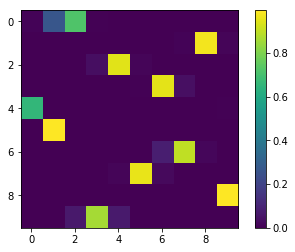

In [24]:
# visualize attention map for some object
# your code here

### Misc

What now? You can:
+ implement and test `AdditiveScore` with learnable parameters $W1$, $W2$ and $w3$
+ implement and test K-headed attention
+ compare attention-based model with baseline, e. g. LSTM
+ replace linear layer (3) in the model with LSTM (autoregressive or not) and try to train such model
+ ...

In [25]:
# play with model and learn something new about attention!